In [2]:
import os
import sys
sys.dont_write_bytecode = True
sys.path.append('..')
import numpy as np
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    BertTokenizer,
    BartTokenizer,
    T5Tokenizer,
    GPT2Tokenizer,
)
from typing import Union, List, Dict, Tuple, Callable
from datasets import load_dataset, Dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# from utils import SentenceEncoder

In [ ]:
from itertools import chain
from typing import List, Optional
from transformers import AutoTokenizer
from transformers.testing_utils import CaptureLogger
from transformers.utils.logging import get_logger


class DGDataset:
    def __init__(
        self, 
        dataset: str = "blended_skill_talk",
        task: str = "seq2seq",
        tokenizer: AutoTokenizer = None,
        max_source_length: int = 512,
        max_target_length: int = 512,
        padding: str = "max_length",
        ignore_pad_token_for_loss: bool = True,
        preprocessing_num_workers: int = None,
        overwrite_cache: bool = True,
    ):
        self.dataset = dataset
        self.task = task
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.padding = padding
        self.ignore_pad_token_for_loss = ignore_pad_token_for_loss
        self.preprocessing_num_workers = preprocessing_num_workers
        self.overwrite_cache = overwrite_cache
        # since this will be pickled to avoid _LazyModule error in Hasher force logger loading before tokenize_function
        self.tok_logger = get_logger("transformers.tokenization_utils_base")


    def prepare_context(self, instance: dict):
        if self.dataset == 'blended_skill_talk':
            num_entries = len(instance["free_messages"])
            total_entries = num_entries
            if self.task == 'seq2seq':
                persona_pieces = f"<PS>{instance['personas'][1]}"
                if instance['context'] == "wizard_of_wikipedia":
                    additional_context_pieces = f"<CTX>{instance['additional_context']}."
                else:
                    additional_context_pieces = ""
                context = persona_pieces + additional_context_pieces
            else:
                num_entries = min(num_entries, 2)
                context = ''
            prev_utt_pc = [sent for sent in instance["previous_utterance"] if sent != '']

        elif self.dataset == 'conv_ai_2':
            total_entries = len(instance['dialog'])
            num_entries = total_entries//2
            if self.task == 'seq2seq':
                user_profile = ' '.join([''.join(x) for x in instance['user_profile']])
                persona_pieces = f"<PS>{user_profile}"
                context = persona_pieces
            else:
                num_entries = min(num_entries, 2)
                context = ''
            prev_utt_pc = []

        elif self.dataset == 'empathetic_dialogues':
            total_entries = len(instance['dialog'])
            num_entries = total_entries//2
            if self.task == 'seq2seq':
                persona_pieces = f"<PS>{instance['prompt']}"
                additional_context_pieces = f"<CTX>{instance['context']}."
                context = persona_pieces + additional_context_pieces
            else:
                num_entries = min(num_entries, 2)
                context = ''
            prev_utt_pc = []

        elif self.dataset == 'AlekseyKorshuk/persona-chat':
            total_entries = len(instance['utterances'])
            num_entries = total_entries//2
            if self.task == 'seq2seq':
                user_profile = ' '.join(instance['personality'])
                persona_pieces = f"<PS>{user_profile}"
                context = persona_pieces
            else:
                num_entries = min(num_entries, 2)
                context = ''
            prev_utt_pc = []

        else:
            raise ValueError("Dataset not supported.")
        return num_entries, total_entries, context, prev_utt_pc


    def prepare_entry(
        self, 
        instance: dict, 
        entry_idx: int, 
        context: str, 
        prev_utt_pc: List[str], 
        total_entries: int,
    ):
        if self.dataset == 'blended_skill_talk':
            free_message = instance['free_messages'][entry_idx]
            guided_message = instance['guided_messages'][entry_idx]
            references = [values[entry_idx] for key, values in instance['suggestions'].items()]

        elif self.dataset == 'conv_ai_2':
            free_message = instance['dialog'][entry_idx*2]['text']
            if entry_idx*2+1 >= total_entries:
                guided_message = None
            else:
                guided_message = instance['dialog'][entry_idx*2+1]['text']
            references = []

        elif self.dataset == 'empathetic_dialogues':
            free_message = instance['dialog'][entry_idx*2]['text']
            if entry_idx*2+1 >= total_entries:
                guided_message = None
            else:
                guided_message = instance['dialog'][entry_idx*2+1]['text']
            references = []

        elif self.dataset == 'AlekseyKorshuk/persona-chat':
            free_message = instance['utterances'][entry_idx*2]['history'][-1]
            if entry_idx*2+1 >= total_entries:
                guided_message = None
            else:
                guided_message = instance['utterances'][entry_idx*2+1]['history'][-1]
            references = instance['utterances'][entry_idx*2]['candidates']
            
        else:
            raise ValueError("Dataset not supported.")

        if not prev_utt_pc:
            original_context = context
        else:
            sp_token = '<SEP>' if self.task == 'seq2seq' else ' '
            original_context = context + sp_token + sp_token.join(prev_utt_pc)
        
        references.append(guided_message)
        return free_message, guided_message, original_context, references


    def tokenize_and_align_labels(self, instance: dict):
        num_entries, total_entries, context, prev_utt_pc = self.prepare_context(instance)
        inputs, labels = [], []
        for entry_idx in range(num_entries):
            free_message, guided_message, original_context, references = self.prepare_entry(
                instance, 
                entry_idx, 
                context, 
                prev_utt_pc,
                total_entries,
            )
            if guided_message is None:
                continue
            # Input & Output
            if self.task == 'seq2seq':
                text = original_context + self.tokenizer.eos_token + free_message
            else:
                text = original_context + free_message + guided_message

            inputs.append(text)
            labels.append(guided_message)
            prev_utt_pc += [
                free_message,
                guided_message,
            ]
        
        if not inputs:
            return {"input_ids": [], "labels": [], "attention_mask": []}

        if self.task == 'seq2seq':
            inputs = self.tokenizer(inputs, max_length=self.max_source_length, padding=self.padding, truncation=True)
            # Setup the tokenizer for targets
            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(labels, max_length=self.max_target_length, padding=self.padding, truncation=True)
            
            # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 
            # when we want to ignore padding in the loss.
            if self.padding == "max_length" and self.ignore_pad_token_for_loss:
                labels["input_ids"] = [
                    [(l if l != self.tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
                ]
            inputs["labels"] = labels["input_ids"]
            return inputs
        else:
            with CaptureLogger(self.tok_logger) as cl:
                inputs = self.tokenizer(
                    inputs, 
                    return_tensors="pt",
                    max_length=self.max_source_length, 
                    padding=self.padding, 
                    truncation=True,
                )
                labels = self.tokenizer(
                    labels, 
                    return_tensors="pt",
                    max_length=self.max_target_length, 
                    padding=self.padding, 
                    truncation=True,
                )
                
            new_inputs = inputs.copy()
            for k, v1 in inputs.items():
                v2 = labels[k]
                new_inputs[k] = torch.cat((v1, v2), dim=1)
                
            new_labels = torch.cat((-100*torch.ones_like(inputs["input_ids"]), labels["input_ids"]), dim=1)
            new_inputs["labels"] = new_labels

            # clm input could be much much longer than block_size
            if "Token indices sequence length is longer than the" in cl.out:
                self.tok_logger.warning(
                    "^^^^^^^^^^^^^^^^ Please ignore the warning above - this long input will be chunked into smaller bits"
                    " before being passed to the model."
                )
            return new_inputs


    def group_texts(self, examples):
        # ['input_ids', 'attention_mask', 'labels']
        concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
        return concatenated_examples


    def group_ED(self, dataset: Dataset):
        results = {
            'conv_id': [], 
            'prompt': [],
            'dialog': [], 
            'context': [],
        }
        for i, instance in enumerate(dataset):
            if instance['utterance_idx'] == 1:
                results['conv_id'].append(instance['conv_id'])
                results['dialog'].append([])
                results['prompt'].append(instance['prompt'])
                results['context'].append(instance['context'])

            response = {'text': instance['utterance'], 'speaker_idx': instance['speaker_idx']}
            results['dialog'][-1].append(response)
        return Dataset.from_dict(results)


    def preprocess(self, dataset: Dataset):
        if self.dataset == "empathetic_dialogues":
            dataset = self.group_ED(dataset)

        dataset = dataset.map(
            self.tokenize_and_align_labels,
            batched=False,
            num_proc=self.preprocessing_num_workers,
            remove_columns=dataset.column_names,
            load_from_cache_file=not self.overwrite_cache,
        )
        dataset = dataset.map(
            self.group_texts,
            batched=True,
            num_proc=self.preprocessing_num_workers,
            load_from_cache_file=not self.overwrite_cache,
        )
        return dataset

In [40]:
model_path = '../ckpt/bart'
data_n = 'blended_skill_talk'
tokenizer = AutoTokenizer.from_pretrained(model_path)
sp_token = tokenizer.eos_token
datasets = load_dataset(data_n)
train_dataset = datasets['train']
val_dataset = datasets['validation']
test_dataset = datasets['test']
# dg = DGDataset(
#     dataset="blended_skill_talk",
#     task="seq2seq",
#     tokenizer=tokenizer,
# )

Found cached dataset blended_skill_talk (/home/yufei/.cache/huggingface/datasets/blended_skill_talk/default/1.0.0/8544e13cbbf2fb9b34157f2e2f28c1539e4f36bf0ef2bd96edd138b4000c5ca1)
100%|██████████| 3/3 [00:00<00:00, 144.65it/s]


In [ ]:
def preprocess(
    dataset: Dataset, 
    tokenizer: Union[BertTokenizer, BartTokenizer, T5Tokenizer, GPT2Tokenizer],
): 
    processed = []
    for i, ins in tqdm(enumerate(dataset)):
        num_entries, total_entries, context, prev_utt_pc = dg.prepare_context(ins)
        for entry_idx in range(num_entries):
            free_message, guided_message, original_context, references = dg.prepare_entry(
                ins, 
                entry_idx, 
                context, 
                prev_utt_pc,
                total_entries,
            )
            if guided_message is None:
                continue
            
            prev_utt_pc += [
                free_message,
                guided_message,
            ]
            
            # Original generation
            text = original_context + sp_token + free_message
            for ref in references:
                processed.append({
                    'src': text,
                    'tgt': ref,
                    'src_len': len(tokenizer.tokenize(text)),
                    'tgt_len': len(tokenizer.tokenize(ref)),
                })
            # processed.append({
            #     'input': text,
            #     'references': references,
            #     'input_length': len(tokenizer.tokenize(text)),
            #     'references_length': [len(tokenizer.tokenize(ref)) for ref in references],
            # })
    processed = pd.DataFrame(processed, columns=['src', 'tgt', 'src_len', 'tgt_len'])
    return processed

data_dir = '../datasets'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
else:
    if os.path.exists(f'{data_dir}/train.tsv'):
        processed_train = pd.read_csv(f'{data_dir}/train.tsv', sep='\t')
    else:
        processed_train = preprocess(train_dataset, tokenizer)
        processed_train.to_csv(f'{data_dir}/train.tsv', sep='\t', index=False)
    if os.path.exists(f'{data_dir}/val.tsv'):
        processed_val = pd.read_csv(f'{data_dir}/val.tsv', sep='\t')
    else:
        processed_val = preprocess(val_dataset, tokenizer)
        processed_val.to_csv(f'{data_dir}/val.tsv', sep='\t', index=False)
    if os.path.exists(f'{data_dir}/dev.tsv'):
        processed_test = pd.read_csv(f'{data_dir}/dev.tsv', sep='\t')
    else:
        processed_test = preprocess(test_dataset, tokenizer)
        processed_test.to_csv(f'{data_dir}/dev.tsv', sep='\t', index=False)

In [ ]:
tgt = "i love acting ! i'll be famous someday . what do you do ?"
inputs = tokenizer(tgt, return_tensors="pt", max_length=128, truncation=True)

### Using a light-weight model to predict the length of a sentence

In [ ]:
grouped_train_df = processed_test.groupby('src', as_index=False).agg(list)
grouped_val_df = processed_val.groupby('src', as_index=False).agg(list)
grouped_test_df = processed_test.groupby('src', as_index=False).agg(list)

In [ ]:
from seq2seq.models import EncoderRNN, DecoderRNN, Seq2seq

model_path = '../../DG_ckpt/bart'
data_n = 'blended_skill_talk'
tokenizer = AutoTokenizer.from_pretrained(model_path)
max_len = 128
hidden_size = 256
input_dropout = 0
dropout = 0.2
n_layers = 1
bidirectional = True
rnn_cell = 'gru'
attention = False


encoder = EncoderRNN(
    vocab_size=tokenizer.__len__(), 
    max_len=max_len, 
    hidden_size=hidden_size,
    input_dropout_p=input_dropout,
    dropout_p=dropout,
    n_layers=n_layers,
    bidirectional=bidirectional, 
    rnn_cell=rnn_cell,
)
decoder = DecoderRNN(
    vocab_size=tokenizer.__len__(), 
    max_len=max_len, 
    hidden_size=hidden_size * 2 if bidirectional else hidden_size,
    sos_id=tokenizer.bos_token_id,
    eos_id=tokenizer.eos_token_id,
    input_dropout_p=input_dropout,
    dropout_p=dropout,
    n_layers=n_layers,
    bidirectional=bidirectional,
    rnn_cell=rnn_cell,
    use_attention=attention,
)
model = Seq2seq(encoder, decoder)

### Embedding + MLP

In [ ]:
# model_path = 'bert-base-uncased'
# config = AutoConfig.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModel.from_pretrained(model_path, config=config)

In [ ]:
# def get_feature(text: Union[str, List[str]], max_len: int = 256):
#     inputs = tokenizer(
#         text, 
#         return_tensors="pt", 
#         max_length=max_len, 
#         padding=True,
#         truncation=True,
#     )
#     input_ids = inputs['input_ids']
#     embed = model.embeddings.word_embeddings.weight
#     return embed[input_ids].detach().numpy()

# src_embeds = get_feature(grouped_train_df['src'].tolist())
# print(src_embeds.shape) # B x T x D

In [ ]:
sent_encoder = SentenceEncoder(device='cuda')

train_src_embeds = sent_encoder.encode(grouped_train_df['src'].tolist())
val_src_embeds = sent_encoder.encode(grouped_val_df['src'].tolist())
test_src_embeds = sent_encoder.encode(grouped_test_df['src'].tolist())

In [ ]:
X_train = train_src_embeds.detach().cpu().numpy()
Y_train = grouped_train_df['tgt_len'].apply(lambda x: np.mean(x)).to_numpy(dtype=np.float32)
print(X_train.shape, Y_train.shape)

X_val = val_src_embeds.detach().cpu().numpy()
Y_val = grouped_val_df['tgt_len'].apply(lambda x: np.mean(x)).to_numpy(dtype=np.float32)
print(X_val.shape, Y_val.shape)

X_test = test_src_embeds.detach().cpu().numpy()
Y_test = grouped_test_df['tgt_len'].apply(lambda x: np.mean(x)).to_numpy(dtype=np.float32)
print(X_test.shape, Y_test.shape)

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)

In [ ]:
regr.predict(sent_encoder.encode(['i love acting ! i\'ll be famous someday . what do you do ?']).detach().cpu().numpy())

In [ ]:
pred_test = regr.predict(X_test)
pred_test_score = regr.score(X_test, Y_test) # the coefficient of determination of the prediction
print('test coefficent: ', pred_test_score)

pred_val = regr.predict(X_val)
pred_val_score = regr.score(X_val, Y_val) # the coefficient of determination of the prediction
print('val coefficent: ', pred_val_score)

In [ ]:
# Fit a linear regression line to the data
coefficients = np.polyfit(pred_test, Y_test, 1)
p = np.poly1d(coefficients)

plt.figure(figsize=(5, 3))
plt.plot(pred_test, Y_test, 'o', label='data')
plt.plot(pred_test, p(pred_test), '-', label='fit')
plt.xlabel('Uncertainty')
plt.ylabel('Length')
plt.savefig('../figures/uncertainty_length.pdf', bbox_inches='tight')
plt.show()

### Using rule-based features to predict the length of a sentence

In [ ]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import word_tokenize

def output_score1(input_sentence):
    # Parse the input sentence with a NLP tool
    doc = nlp(input_sentence)

    # Calculate a base score based on the number of words
    num_words = len(doc)
    base_score = num_words / 30  # Assumes that an average sentence length is around 30 words

    # Adjust the score based on the linguistic properties of the input sentence
    for token in doc:
        # Increase score for longer words
        if len(token.text) > 6:
            base_score += 0.1

        # Increase score for complex syntactic structures
        if token.dep_ in ["ccomp", "xcomp", "advcl", "relcl", "acl"]:
            base_score += 0.2

        # Increase score for ambiguous or multi-interpretation sentences
        if token.pos_ in ["VERB", "NOUN", "ADJ"]:
            for child in token.children:
                if child.pos_ == "NOUN" or child.pos_ == "ADJ":
                    base_score += 0.1
                if child.dep_ == "advmod":
                    base_score += 0.1

        # Increase score for dense information sentences
        if token.pos_ == "NOUN" or token.pos_ == "VERB":
            if len(token.text) > 4:
                base_score += 0.1
                
    return base_score


def output_score2(input_sentence):
    score = 0
    
    # Check for open-ended questions
    if input_sentence.endswith("?"):
        score += 2
        
    # Check for ambiguous or vague language
    if len(input_sentence.split()) > 10:
        score += 1
        
    # Check for multi-part questions
    num_commas = len(re.findall(",", input_sentence))
    num_and = len(re.findall(" and ", input_sentence))
    if num_commas > 0 or num_and > 0:
        score += num_commas + num_and
        
    # Check for unfamiliar or complex terminology
    doc = nlp(input_sentence)
    tech_terms = ["epigenetics", "gene expression", "artificial intelligence", "machine learning"]
    num_tech_terms = sum([1 for token in doc if token.text.lower() in tech_terms])
    score += num_tech_terms
    
    # Check for abstract or philosophical concepts
    abs_terms = ["consciousness", "self", "reality", "ontology", "phenomenology"]
    num_abs_terms = sum([1 for token in doc if token.text.lower() in abs_terms])
    score += num_abs_terms
    
    return score


def output_score3(input_sentence):
    score = 0
    
    # Check for open-ended questions
    if input_sentence.endswith("?"):
        score += 2
        
    # Check for ambiguous or vague language
    if len(input_sentence.split()) > 10:
        score += 1
        
    # Check for multi-part questions
    num_commas = len(re.findall(",", input_sentence))
    num_and = len(re.findall(" and ", input_sentence))
    if num_commas > 0 or num_and > 0:
        score += num_commas + num_and
        
    # Check for unfamiliar or complex terminology
    doc = nlp(input_sentence)
    for token in doc:
        if token.lemma_ in ["epigenetic", "gene expression"]:
            score += 3
        
    # Check for abstract or philosophical concepts
    if "nature of consciousness" in input_sentence or "self and the world" in input_sentence:
        score += 4
        
    # Tokenize input sentence
    tokens = word_tokenize(input_sentence)
    
    # Count number of tokens
    num_tokens = len(tokens)
    
    # Calculate average length of tokens
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    
    # Adjust score based on token length
    if avg_token_length > 8:
        score += 1
    elif avg_token_length > 10:
        score += 2
    elif avg_token_length > 12:
        score += 3
    
    return score

In [ ]:
def rule_UE_predict(df: pd.DataFrame, func: Callable):
    rule_ue = df['src'].apply(func)
    xx, yy = [], []
    for i, row in df.iterrows():
        xx.extend([rule_ue[i]] * len(row['tgt_len']))
        yy.extend(row['tgt_len'])
    return xx, yy

In [36]:
# Fit a linear regression line to the data
def fit_data(xx, yy, x_label=None, y_label=None, title=None, save_path=None):
    coefficients = np.polyfit(xx, yy, 1)
    p = np.poly1d(coefficients)

    plt.figure(figsize=(5, 3))
    plt.plot(xx, yy, 'o', label='data')
    plt.plot(xx, p(xx), '-', label='fit')
    if x_label is None:
        x_label = 'Uncertainty'
    if y_label is None:
        y_label = 'Length'
    if title is None:
        title = 'Uncertainty vs. Length'
    if save_path is None:
        save_path = '../figures/uncertainty_length.pdf'
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
xx1, yy1 = rule_UE_predict(grouped_test_df, output_score1)
xx2, yy2 = rule_UE_predict(grouped_test_df, output_score2)
xx3, yy3 = rule_UE_predict(grouped_test_df, output_score3)

In [ ]:
fit_data(xx1, yy1)

In [ ]:
fit_data(xx2, yy2)

In [ ]:
fit_data(xx3, yy3)

In [ ]:
def open_ended_question_score(input_sentence):
    if input_sentence.endswith("?"):
        return 1.0
    else:
        return 0.0

def ambiguous_language_score(input_sentence):
    if len(input_sentence.split()) > 10:
        return 0.5
    else:
        return 0.0

def multi_part_question_score(input_sentence):
    num_commas = len(re.findall(",", input_sentence))
    num_and = len(re.findall(" and ", input_sentence))
    num_parts = num_commas + num_and
    return num_parts * 0.5

def unfamiliar_terminology_score(input_sentence):
    doc = nlp(input_sentence)
    unfamiliar_terms = 0
    for token in doc:
        if token.lemma_ in ["epigenetic", "gene expression", "quantum mechanics", "neuroplasticity", "postmodernism"]:
            unfamiliar_terms += 1
    return unfamiliar_terms * 0.5

def abstract_concepts_score(input_sentence):
    if "nature of consciousness" in input_sentence or "self and the world" in input_sentence or "meaning of life" in input_sentence:
        return 1.0
    else:
        return 0.0
    
def token_length_score(input_sentence):
    tokens = word_tokenize(input_sentence)
    num_tokens = len(tokens)
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    if avg_token_length > 12:
        return 1.0
    elif avg_token_length > 10:
        return 0.5
    else:
        return 0.0
    
def input_length_score(input_sentence):
    if len(input_sentence) > 200:
        return 1.0
    elif len(input_sentence) > 100:
        return 0.5
    else:
        return 0.0

def output_score4(input_sentence):
    score = open_ended_question_score(input_sentence)
    score += ambiguous_language_score(input_sentence)
    score += multi_part_question_score(input_sentence)
    score += unfamiliar_terminology_score(input_sentence)
    score += abstract_concepts_score(input_sentence)
    score += token_length_score(input_sentence)
    score += input_length_score(input_sentence)
    return score

In [ ]:
xx4, yy4 = rule_UE_predict(grouped_test_df, open_ended_question_score)
xx5, yy5 = rule_UE_predict(grouped_test_df, ambiguous_language_score)
xx6, yy6 = rule_UE_predict(grouped_test_df, multi_part_question_score)
xx7, yy7 = rule_UE_predict(grouped_test_df, token_length_score)
xx8, yy8 = rule_UE_predict(grouped_test_df, input_length_score)

In [ ]:
fit_data(xx4, yy4)

In [ ]:
fit_data(xx5, yy5)

In [ ]:
fit_data(xx6, yy6)

In [ ]:
fit_data(xx8, yy8)

In [60]:
import ast
def eval_list(x):
    return ast.literal_eval(x)

def get_output_length(refs: List[str]):
    return [len(tokenizer.tokenize(ref)) for ref in refs]

bart_df = pd.read_csv("../results/bart_BST_10.csv")
bart_df['refs'] = bart_df['refs'].apply(eval_list)
bart_df['ref_lens'] = bart_df['refs'].apply(get_output_length)
bart_df['lw_ue'] = bart_df['lw_ue'].apply(lambda x: eval_list(x)[0])
# bart_df['lw_ue'] = bart_df['lw_ue'].apply(lambda x: x[0])
bart_df.head()

,model,src,pred,pred_len,refs,bleu,rouge,meteor,infer_time,lw_ue,lw_time,rule1_ue,rule1_time,rule2_ue,rule2_time,rule3_ue,rule3_time,rule4_ue,rule4_time,ref_lens
0,bart,<PS>i am a grandparent at 44.<SEP>what do you ...,No i do not. But i wish someday after getting ...,23,"[no my daughters . do you have any children ?,...",0.081041,0.296296,0.506592,3.048796,14.578398,0.186359,5.566667,0.289377,6,0.474823,6,0.238815,4.0,0.259709,"[10, 8, 18, 13]"
1,bart,<PS>i am a grandparent at 44.<SEP>what do you ...,I love to read. What about you?,9,[i am a night lover and worked 2nd shift since...,0.158279,0.153846,0.179710,1.766788,17.297370,0.334299,7.666667,0.335512,7,0.255143,7,0.503494,4.5,0.453187,"[13, 20, 19, 24]"
2,bart,<PS>i am a grandparent at 44.<SEP>what do you ...,I think it will be something that he will real...,25,[maybe . my two daughters would enjoy that . d...,0.068716,0.121212,0.128205,4.096246,23.189583,0.613650,12.466667,0.656929,8,0.336986,8,0.512887,5.0,0.473931,"[14, 10, 26, 27]"
3,bart,<PS>i am a grandparent at 44.<SEP>what do you ...,Good idea! I hope to teach soccer to my son as...,14,[i love photos ! you take them in your hometow...,0.111149,0.095238,0.088496,2.026502,23.189583,0.395968,17.733333,0.599669,7,0.469609,7,0.474061,4.5,0.456050,"[11, 11, 10, 23]"
4,bart,<PS>i am a grandparent at 44.<SEP>what do you ...,Good idea! I hope to teach soccer to my son as...,14,[i love photos ! you take them in your hometow...,0.111149,0.173913,0.098522,2.276340,23.189583,0.296657,22.566667,0.401792,12,0.679572,12,0.404660,7.0,0.419896,"[11, 14, 10, 21]"


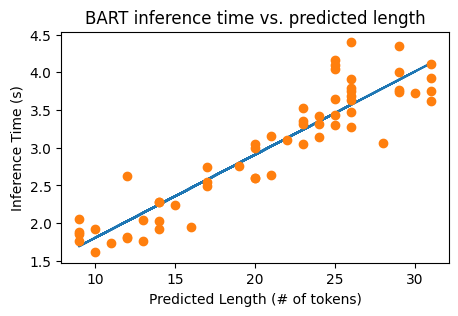

In [35]:
plt.figure(figsize=(5, 3))
coefficients = np.polyfit(bart_df['pred_len'], bart_df['infer_time'], 1)
p = np.poly1d(coefficients)
plt.plot(bart_df['pred_len'], p(bart_df['pred_len']), '-', label='fit')
plt.plot(bart_df['pred_len'], bart_df['infer_time'], 'o', label='infer vs pred')
plt.xlabel('Predicted Length (# of tokens)')
plt.ylabel('Inference Time (s)')
plt.title('BART inference time vs. predicted length')
plt.savefig('../figures/bart_infer_time.pdf', bbox_inches='tight')
plt.show()

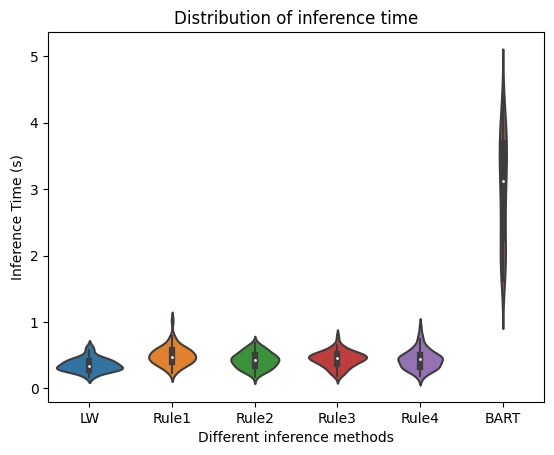

In [34]:
import seaborn as sns

# plt.figure(figsize=(5, 3))
# Extract a subset of the DataFrame with columns A, B, and C
df_sub = bart_df[['lw_time', 'rule1_time', 'rule2_time', 'rule3_time', 'rule4_time', 'infer_time']]
# Convert the subset of the DataFrame from wide to long format using melt
df_melt = pd.melt(df_sub, var_name='column')
# Create a dictionary that maps the original column names to new display names
column_map = {'lw_time': 'LW', 'rule1_time': 'Rule1', 'rule2_time': 'Rule2', 'rule3_time': 'Rule3', 'rule4_time': 'Rule4', 'infer_time': 'BART'}
# Apply the mapping to the column names in the long format DataFrame
df_melt['column'] = df_melt['column'].map(column_map)

# Plot the distribution of values in each column
sns.violinplot(x='column', y='value', data=df_melt)
# Add labels and title to the plot
plt.xlabel('Different inference methods')
plt.ylabel('Inference Time (s)')
plt.title('Distribution of inference time')
plt.savefig('../figures/bart_infer_time_dist.pdf', bbox_inches='tight')
# Display the plot
plt.show()

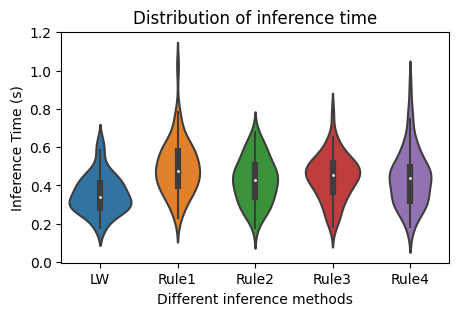

In [32]:
plt.figure(figsize=(5, 3))
# Extract a subset of the DataFrame with columns A, B, and C
df_sub = bart_df[['lw_time', 'rule1_time', 'rule2_time', 'rule3_time', 'rule4_time']]
# Convert the subset of the DataFrame from wide to long format using melt
df_melt = pd.melt(df_sub, var_name='column')
# Create a dictionary that maps the original column names to new display names
column_map = {'lw_time': 'LW', 'rule1_time': 'Rule1', 'rule2_time': 'Rule2', 'rule3_time': 'Rule3', 'rule4_time': 'Rule4'}
# Apply the mapping to the column names in the long format DataFrame
df_melt['column'] = df_melt['column'].map(column_map)

# Plot the distribution of values in each column
sns.violinplot(x='column', y='value', data=df_melt)
# Add labels and title to the plot
plt.xlabel('Different inference methods')
plt.ylabel('Inference Time (s)')
plt.title('Distribution of inference time')
plt.savefig('../figures/basic_infer_time_dist.pdf', bbox_inches='tight')
# Display the plot
plt.show()

#### Uncertainty vs. Length (patterns)

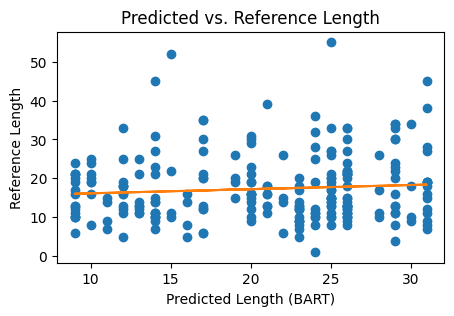

In [53]:
xx, yy = [], []
for i, row in bart_df.iterrows():
    xx.extend([row['pred_len']] * len(row['ref_lens']))
    yy.extend(row['ref_lens'])

fit_data(xx, yy, 
         x_label='Predicted Length (BART)', 
         y_label='Reference Length', 
         title='Predicted vs. Reference Length', 
         save_path='../figures/predicted_reference_length.pdf')

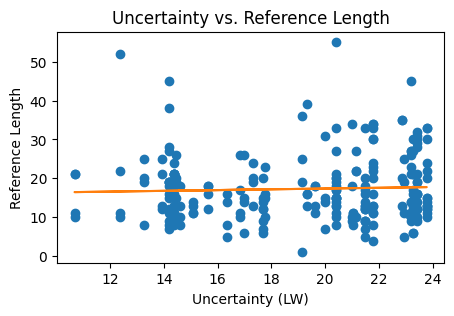

In [61]:
xx, yy = [], []
for i, row in bart_df.iterrows():
    xx.extend([row['lw_ue']] * len(row['ref_lens']))
    yy.extend(row['ref_lens'])

# print(xx, yy)

fit_data(xx, yy, 
         x_label='Uncertainty (LW)', 
         y_label='Reference Length', 
         title='Uncertainty vs. Reference Length', 
         save_path='../figures/uncertainty_reference_LW.pdf')